In [3]:
from typing import Annotated, TypedDict

from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.checkpoint.memory import MemorySaver

class State(TypedDict):
    messages: Annotated[list, add_messages]

builder = StateGraph(State)

In [4]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model='gpt-4o-mini')

def chatbot(state: State):
    answer = model.invoke(state['messages'])
    return {'messages': [answer]}

builder.add_node('chatbot', chatbot)

In [5]:
builder.add_edge(START, 'chatbot')
builder.add_edge('chatbot', END)

graph = builder.compile()

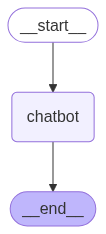

In [7]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [8]:
input = {'messages': [HumanMessage('안녕하세요!')]}
for chunk in graph.stream(input):
    print(chunk)

{'chatbot': {'messages': [AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 10, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--1b34e75e-b0f2-4487-9889-06ffbb4897ed-0', usage_metadata={'input_tokens': 10, 'output_tokens': 10, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}


# 4.4 StateGraph에 메모리 기능 추가
langgraph에 영속성 추가 -> 랭그래프 전용 스토리지 어댑터인 체크포인터 첨부해 재컴파일

In [9]:
from langgraph.checkpoint.memory import MemorySaver

graph = builder.compile(checkpointer=MemorySaver())

In [12]:
thread1 = {'configurable': {'thread_id': '1'}}

result_1 = graph.invoke({
    'messages': [HumanMessage('안녕하세요, 저는 민혁입니다!')]
}, thread1)

result_2 = graph.invoke({
    'messages': [HumanMessage('제 이름이 뭐죠?')]
}, thread1)

result_2

{'messages': [HumanMessage(content='안녕하세요, 저는 민혁입니다!', additional_kwargs={}, response_metadata={}, id='9e37b7ac-a787-4a72-9239-7874be3837ec'),
  AIMessage(content='안녕하세요, 민혁님! 만나서 반갑습니다. 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 15, 'total_tokens': 35, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--4dd27b1f-1d8a-4411-8196-37ca839f6b1a-0', usage_metadata={'input_tokens': 15, 'output_tokens': 20, 'total_tokens': 35, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='안녕하세요, 저는 민혁입니다!', additional_kwargs={}, response_metadata={}, id='25271b52-fabe-4

In [13]:
graph.get_state(thread1)

StateSnapshot(values={'messages': [HumanMessage(content='안녕하세요, 저는 민혁입니다!', additional_kwargs={}, response_metadata={}, id='9e37b7ac-a787-4a72-9239-7874be3837ec'), AIMessage(content='안녕하세요, 민혁님! 만나서 반갑습니다. 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 15, 'total_tokens': 35, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--4dd27b1f-1d8a-4411-8196-37ca839f6b1a-0', usage_metadata={'input_tokens': 15, 'output_tokens': 20, 'total_tokens': 35, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='안녕하세요, 저는 민혁입니다!', additional_kwargs={}, response_metadata={}, id

In [14]:
graph.update_state(thread1, {'messages': [HumanMessage('저는 LLM이 좋아요!')]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f06570e-6c35-6e84-800e-a6ec3dd306da'}}

# 4.5 채팅기록 수정

채팅 기록 메시지는 채팅 모델이 좋은 응답 값 생성에 부족함
-> 채팅 기록 수정
기법
1. 메시지 축약 - trimming
2. 내용 필터링 - filtering
3. 메시지 병합 - merging

## 메시지 축약
context window 제한

In [15]:
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    AIMessage,
    trim_messages
)
from langchain_openai import ChatOpenAI

message = [
    SystemMessage('당신은 친절한 어시스턴트입니다. 모든 질문에 최선을 다해 답하세요.'),
    HumanMessage('안녕하세요! 저는 민혁입니다!'),
    AIMessage('안녕하세요!'),
    HumanMessage('바닐라 아이스크림을 좋아해요!'),
    AIMessage('좋네요!'),
    HumanMessage('2 + 2는 얼마죠?'),
    AIMessage('4 입니다.!'),
    HumanMessage('고마워요.'),
]

trimmer = trim_messages(
    max_tokens=65,
    strategy='last',
    token_counter=ChatOpenAI(model='gpt-4o-mini'),
    include_system=True,
    allow_partial=False,
    start_on='human'
)

trimmed = trimmer.invoke(message)

trimmed

[SystemMessage(content='당신은 친절한 어시스턴트입니다. 모든 질문에 최선을 다해 답하세요.', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='2 + 2는 얼마죠?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='4 입니다.!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='고마워요.', additional_kwargs={}, response_metadata={})]

## 내용 필터링

`filter_messages` 헬퍼를 사용해 채팅 기록 메시지를 유형, ID, 이름별로 쉽게 구분가능

In [20]:
from langchain_core.messages import (
    AIMessage,
    HumanMessage,
    SystemMessage,
    filter_messages
)

messages = [
    SystemMessage(content='당신은 친절한 어시스턴트입니다.', id='1'),
    HumanMessage(content='예시 입력', id='2', name='example_user'),
    AIMessage(content='예시 출력', id='3', name='example_assistant'),
    HumanMessage(content='실제 입력', id='4', name='bob'),
    AIMessage(content='실제 출력', id='5', name='alice'),
]

human_messages = filter_messages(messages, include_types='human')
human_messages

[HumanMessage(content='예시 입력', additional_kwargs={}, response_metadata={}, name='example_user', id='2'),
 HumanMessage(content='실제 입력', additional_kwargs={}, response_metadata={}, name='bob', id='4')]

In [23]:
excluded_names = filter_messages(
    messages, exclude_names=['example_user', 'example_assistant']
)
print('\n이름에 example이 포함되지 않은 메시지:', excluded_names)

filtered_messages = filter_messages(
    messages, include_types=['human', 'ai'], exclude_ids=['3']
)
print('\n특정 유형과 ID로 필터링한 메시지:', filtered_messages)


이름에 example이 포함되지 않은 메시지: [SystemMessage(content='당신은 친절한 어시스턴트입니다.', additional_kwargs={}, response_metadata={}, id='1'), HumanMessage(content='실제 입력', additional_kwargs={}, response_metadata={}, name='bob', id='4'), AIMessage(content='실제 출력', additional_kwargs={}, response_metadata={}, name='alice', id='5')]

특정 유형과 ID로 필터링한 메시지: [HumanMessage(content='예시 입력', additional_kwargs={}, response_metadata={}, name='example_user', id='2'), HumanMessage(content='실제 입력', additional_kwargs={}, response_metadata={}, name='bob', id='4'), AIMessage(content='실제 출력', additional_kwargs={}, response_metadata={}, name='alice', id='5')]


선언형으로 필터링

In [24]:
model = ChatOpenAI()

filter_ = filter_messages(exclude_names=['example_user', 'example_assistant'])

chain = filter_ | model

## 연속된 메시지 병합

In [25]:
from langchain_core.messages import (
    AIMessage,
    HumanMessage,
    SystemMessage,
    merge_message_runs
)

messages = [
    SystemMessage(content='당신은 친절한 어시스턴트입니다'),
    SystemMessage(content='항상 농담으로 대답하세요'),
    HumanMessage(
        content=[{'type': 'text', 'text': '어떤 피자가 제일 맛있나요?'}]
    ),
    HumanMessage(
        content='어떤 햄버거가 가장 맛있나요?'
    ),
    AIMessage(
        content=[{'type': 'text', 'text': '피자가 제일 맛있어요!'}]
    ),
    AIMessage(
        content='나는 항상 너만 "고르곤졸라"'
    ),
    AIMessage(
        content='너가 "버거" 싶어'
    )
]

merged = merge_message_runs(messages)

In [26]:
merged

[SystemMessage(content='당신은 친절한 어시스턴트입니다\n항상 농담으로 대답하세요', additional_kwargs={}, response_metadata={}),
 HumanMessage(content=[{'type': 'text', 'text': '어떤 피자가 제일 맛있나요?'}, '어떤 햄버거가 가장 맛있나요?'], additional_kwargs={}, response_metadata={}),
 AIMessage(content=[{'type': 'text', 'text': '피자가 제일 맛있어요!'}, '나는 항상 너만 "고르곤졸라"너가 "버거" 싶어'], additional_kwargs={}, response_metadata={})]

선언형 merge

In [27]:
model = ChatOpenAI(model="gpt-4o-mini")
merger = merge_message_runs()
chain = merger | model